In [46]:
# Cell 1: Imports and Functions Definitions

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, Binarizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Function to preprocess assets and liabilities
def preprocess_assets_liabilities(value):
    if 'Crore' in value:
        return float(value.split()[0])
    elif 'Lac' in value:
        return float(value.split()[0]) / 100
    elif 'Thou' in value:
        return float(value.split()[0]) / 10000
    elif 'Hund' in value:
        return float(value.split()[0]) / 100000
    else:
        return 0

# Binning function for criminal cases
def bin_criminal_cases(number_of_cases):
    if number_of_cases <= 5:
        return 1
    elif number_of_cases <= 15:
        return 2
    else:
        return 3


In [47]:
# Cell 2: Data Loading

# Load the datasets
train_data = pd.read_csv('train.csv')
test_data_all = pd.read_csv('test.csv')

print("Data loaded successfully. Training data shape:", train_data.shape, "Test data shape:", test_data_all.shape)


Data loaded successfully. Training data shape: (2059, 9) Test data shape: (1374, 8)


In [48]:
# Cell 3: Feature Selection and Encoding

# Keep only the required features
required_features = ['Party', 'Criminal Case', 'Total Assets', 'Liabilities', 'state', 'Education']
train_data = train_data[required_features]
test_data = test_data_all[['Party', 'Criminal Case', 'Total Assets', 'Liabilities', 'state']]

# Label encode 'Education' column
label_encoder = LabelEncoder()
train_data['Education'] = label_encoder.fit_transform(train_data['Education'])

print("Features selected and encoded. Sample data:\n", train_data.head())


Features selected and encoded. Sample data:
   Party  Criminal Case Total Assets Liabilities           state  Education
0   DMK              4   211 Crore+    2 Crore+      TAMIL NADU          3
1   BJP              0     1 Crore+           0  MADHYA PRADESH          1
2   INC              0     7 Crore+     22 Lac+       KARNATAKA          9
3   BJP              0     9 Crore+     24 Lac+           BIHAR          9
4   BJP              2     2 Crore+     61 Lac+     WEST BENGAL          3


In [49]:
# Cell 4: Data Preprocessing

# Preprocess 'Total Assets' and 'Liabilities'
train_data['Total Assets'] = train_data['Total Assets'].apply(preprocess_assets_liabilities)
train_data['Liabilities'] = train_data['Liabilities'].apply(preprocess_assets_liabilities)
test_data['Total Assets'] = test_data['Total Assets'].apply(preprocess_assets_liabilities)
test_data['Liabilities'] = test_data['Liabilities'].apply(preprocess_assets_liabilities)

# One-hot encoding for 'state' and 'Party'
train_data = pd.get_dummies(train_data, columns=['state', 'Party'])
test_data = pd.get_dummies(test_data, columns=['state', 'Party'])

# Binning 'Criminal Case'
train_data['Criminal Case'] = train_data['Criminal Case'].apply(bin_criminal_cases)
test_data['Criminal Case'] = test_data['Criminal Case'].apply(bin_criminal_cases)

print("Data preprocessed. Sample data after preprocessing:\n", train_data.head())


Data preprocessed. Sample data after preprocessing:
    Criminal Case  Total Assets  Liabilities  Education  state_ANDHRA PRADESH  \
0              1         211.0         2.00          3                 False   
1              1           1.0         0.00          1                 False   
2              1           7.0         0.22          9                 False   
3              1           9.0         0.24          9                 False   
4              1           2.0         0.61          3                 False   

   state_ARUNACHAL PRADESH  state_ASSAM  state_BIHAR  state_CHHATTISGARH  \
0                    False        False        False               False   
1                    False        False        False               False   
2                    False        False        False               False   
3                    False        False         True               False   
4                    False        False        False               False   

   state_

C:\Users\havis\AppData\Local\Temp\ipykernel_53076\1775519127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Total Assets'] = test_data['Total Assets'].apply(preprocess_assets_liabilities)
C:\Users\havis\AppData\Local\Temp\ipykernel_53076\1775519127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Liabilities'] = test_data['Liabilities'].apply(preprocess_assets_liabilities)


In [50]:
# Cell 5: Feature Binarization

# Binarizing 'Total Assets' and 'Liabilities'
binarizer_assets_liabilities = Binarizer()
train_data[['Total Assets', 'Liabilities']] = binarizer_assets_liabilities.fit_transform(train_data[['Total Assets', 'Liabilities']])
test_data[['Total Assets', 'Liabilities']] = binarizer_assets_liabilities.transform(test_data[['Total Assets', 'Liabilities']])

# Binarizing 'Criminal Case' after binning
binarizer_criminal_cases = Binarizer(threshold=1.5)  # Threshold to differentiate between low and high criminal cases
train_data['Criminal Case'] = binarizer_criminal_cases.fit_transform(train_data[['Criminal Case']])
test_data['Criminal Case'] = binarizer_criminal_cases.transform(test_data[['Criminal Case']])

print("Features binarized. Sample data:\n", train_data.head())


Features binarized. Sample data:
    Criminal Case  Total Assets  Liabilities  Education  state_ANDHRA PRADESH  \
0              0           1.0          1.0          3                 False   
1              0           1.0          0.0          1                 False   
2              0           1.0          1.0          9                 False   
3              0           1.0          1.0          9                 False   
4              0           1.0          1.0          3                 False   

   state_ARUNACHAL PRADESH  state_ASSAM  state_BIHAR  state_CHHATTISGARH  \
0                    False        False        False               False   
1                    False        False        False               False   
2                    False        False        False               False   
3                    False        False         True               False   
4                    False        False        False               False   

   state_DELHI  ...  Party_N

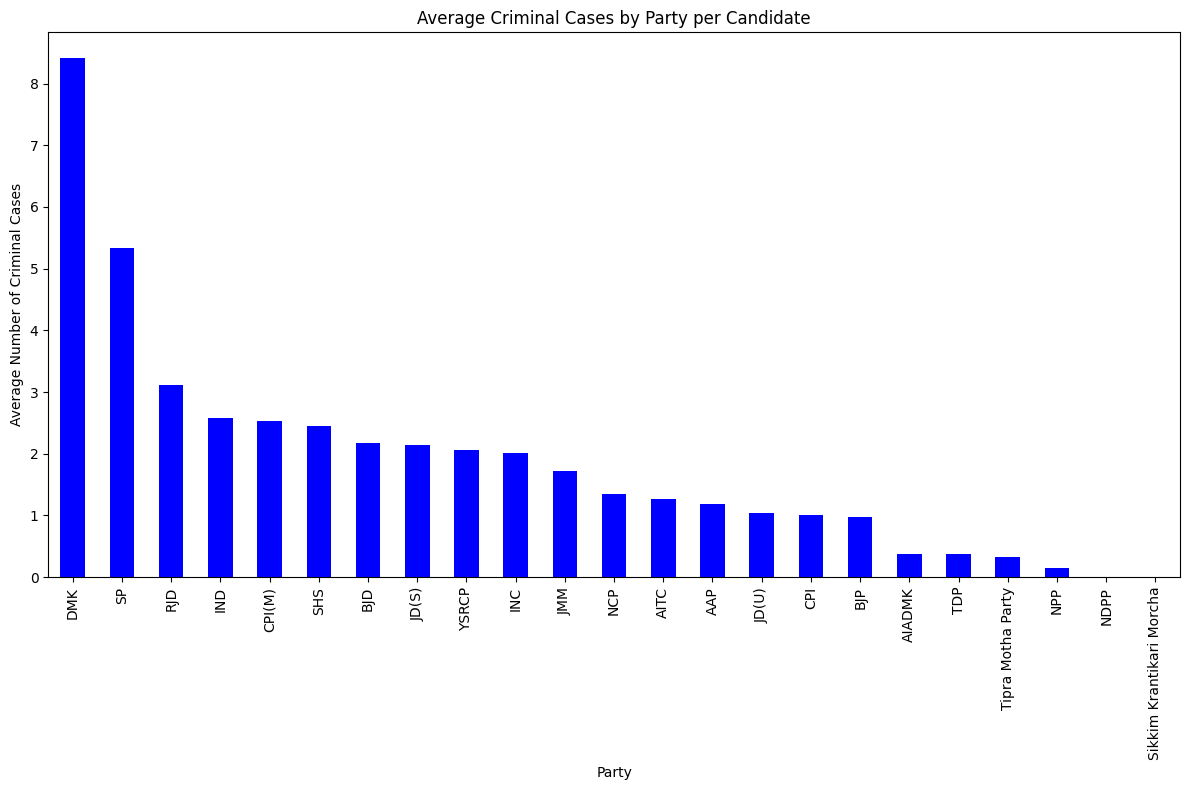

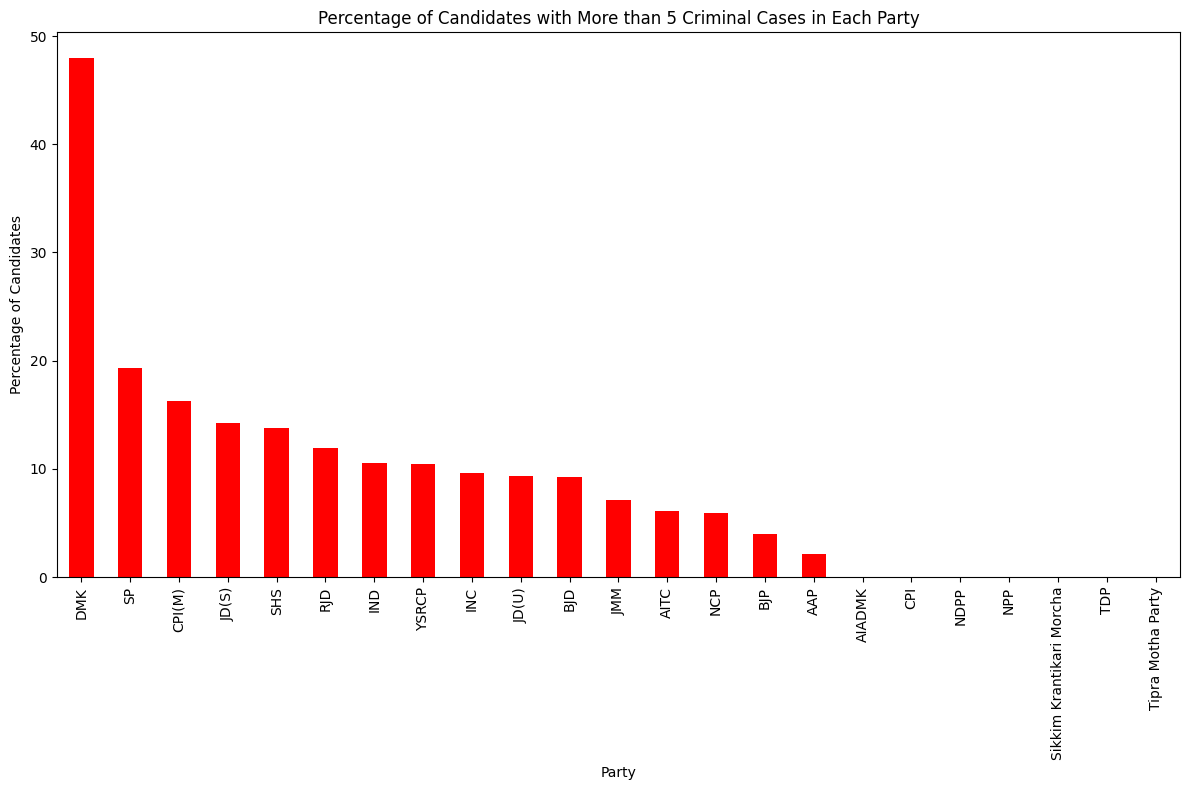

In [51]:
# Cell 6: Data Visualization - Part 1

# Re-load the data to use unmodified data for visualizations
data_visualization = pd.read_csv('train.csv')

# Visualization 1: Average Criminal Cases by Party per Candidate
average_cases_by_party = data_visualization.groupby('Party')['Criminal Case'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
average_cases_by_party.plot(kind='bar', color='blue')
plt.title('Average Criminal Cases by Party per Candidate')
plt.ylabel('Average Number of Criminal Cases')
plt.xlabel('Party')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Visualization 3: Percentage of Candidates with More than 5 Criminal Cases in Each Party
cases_threshold = 5
total_candidates_per_party = data_visualization['Party'].value_counts()
candidates_above_threshold_per_party = data_visualization[data_visualization['Criminal Case'] > cases_threshold].groupby('Party').size()
percentage_above_threshold_per_party = (candidates_above_threshold_per_party / total_candidates_per_party) * 100
percentage_above_threshold_per_party = percentage_above_threshold_per_party.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
percentage_above_threshold_per_party.plot(kind='bar', color='red')
plt.title('Percentage of Candidates with More than 5 Criminal Cases in Each Party')
plt.ylabel('Percentage of Candidates')
plt.xlabel('Party')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


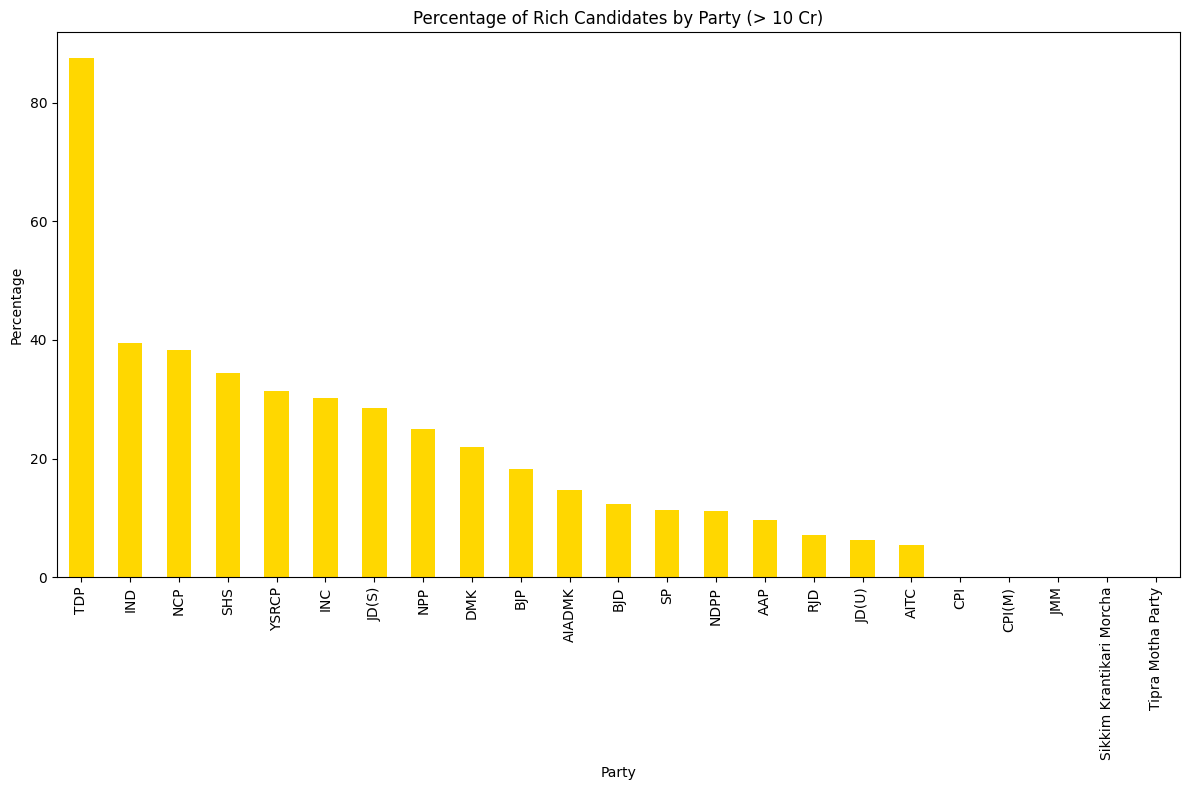

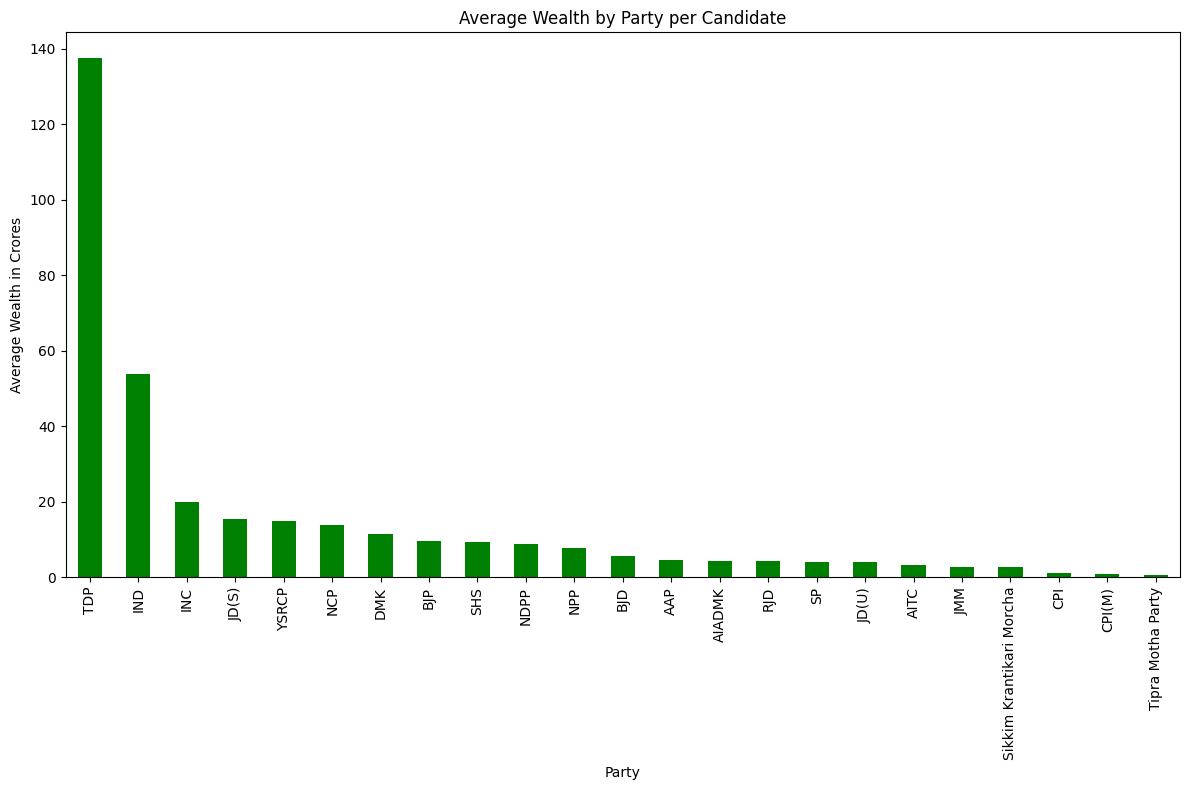

In [52]:
# Cell 7: Data Visualization - Part -2

# Re-load the data to use unmodified data for visualizations
data_visualization = pd.read_csv('train.csv')

# Define the wealth threshold
wealth_threshold = 10  # Representing 10 Crores

# Process the 'Total Assets' to a numeric value in Crores
data_visualization['Total Assets in Crores'] = data_visualization['Total Assets'].apply(preprocess_assets_liabilities)

# Visualization 1: Percentage of Rich Candidates by Party (> 10 Cr)
rich_candidates = data_visualization[data_visualization['Total Assets in Crores'] > wealth_threshold]
total_candidates_per_party = data_visualization['Party'].value_counts()
rich_candidates_per_party = rich_candidates['Party'].value_counts()
percentage_rich_per_party = (rich_candidates_per_party / total_candidates_per_party) * 100
percentage_rich_per_party = percentage_rich_per_party.sort_values(ascending=False)  # Sort for better visualization

plt.figure(figsize=(12, 8))
percentage_rich_per_party.plot(kind='bar', color='gold')
plt.title('Percentage of Rich Candidates by Party (> 10 Cr)')
plt.ylabel('Percentage')
plt.xlabel('Party')
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

# Visualization 2: Average Wealth by Party per Candidate
average_wealth_by_party = data_visualization.groupby('Party')['Total Assets in Crores'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
average_wealth_by_party.plot(kind='bar', color='green')
plt.title('Average Wealth by Party per Candidate')
plt.ylabel('Average Wealth in Crores')
plt.xlabel('Party')
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


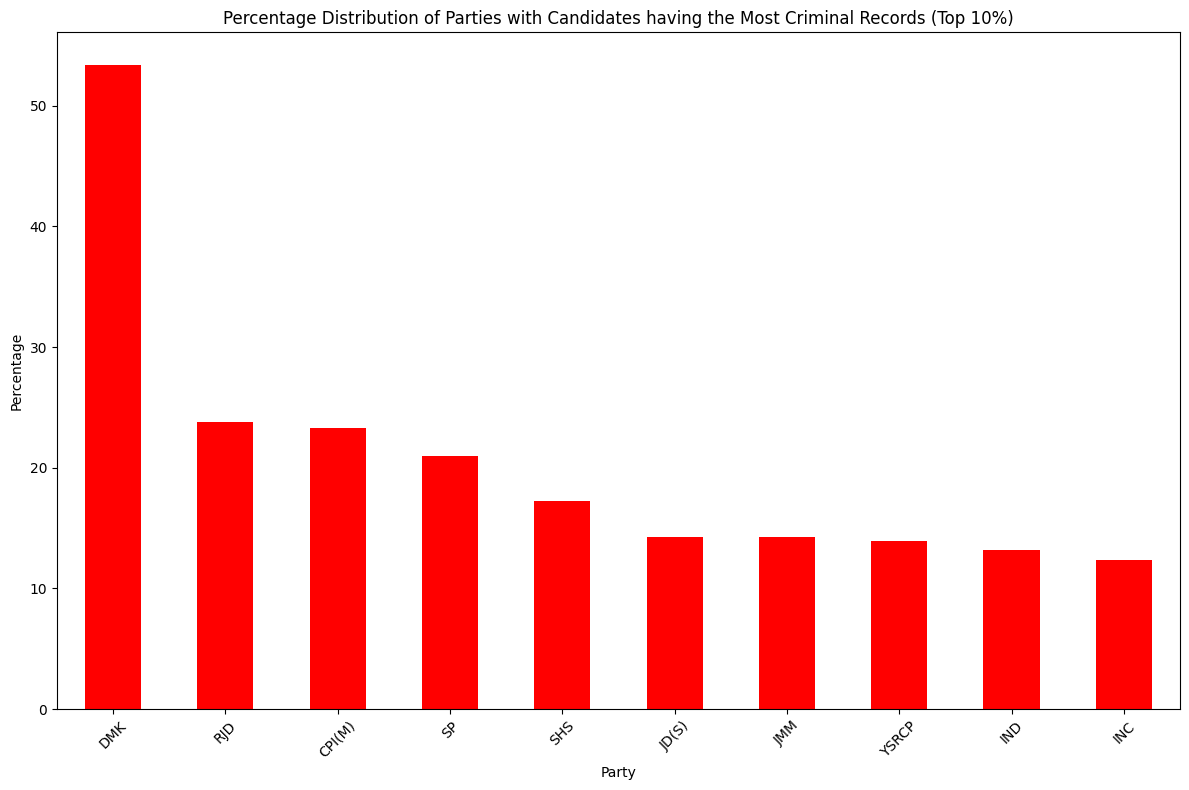

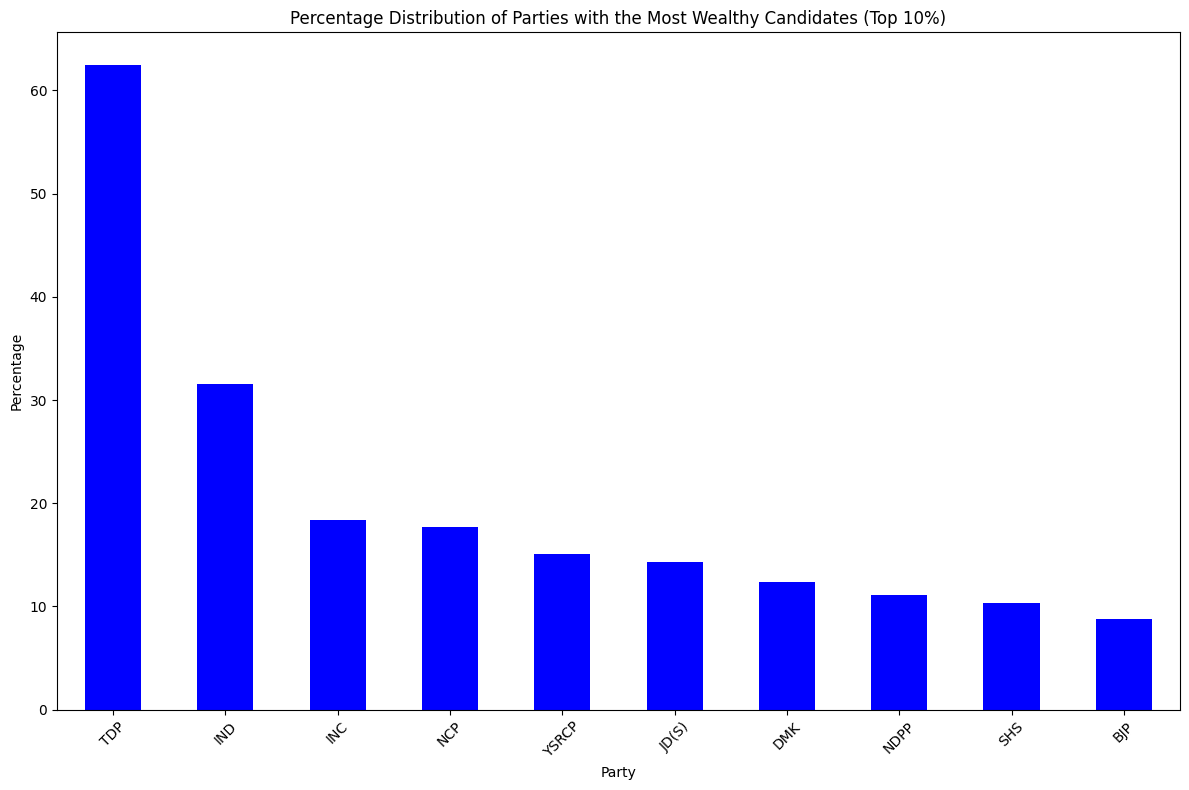

In [53]:
# Cell 8: Data Visualization - Part-3

# Re-load the data to use unmodified data for visualizations
data_visualization = pd.read_csv('train.csv')

# Process 'Total Assets' to a numeric value in Crores
data_visualization['Total Assets in Crores'] = data_visualization['Total Assets'].apply(preprocess_assets_liabilities)

# Calculate the threshold for the top 10% in criminal cases and wealth
criminal_threshold = data_visualization['Criminal Case'].quantile(0.90)
wealth_threshold = data_visualization['Total Assets in Crores'].quantile(0.90)

# Identify the top 10% candidates by criminal records and wealth
top_criminals = data_visualization[data_visualization['Criminal Case'] >= criminal_threshold]
top_wealthy = data_visualization[data_visualization['Total Assets in Crores'] >= wealth_threshold]

# Calculate the distribution of these candidates across parties
top_criminal_party_distribution = (top_criminals['Party'].value_counts() / data_visualization['Party'].value_counts()) * 100
top_wealthy_party_distribution = (top_wealthy['Party'].value_counts() / data_visualization['Party'].value_counts()) * 100

# Sort and filter to keep visualization clean (if too many parties)
top_criminal_party_distribution = top_criminal_party_distribution.sort_values(ascending=False).head(10)
top_wealthy_party_distribution = top_wealthy_party_distribution.sort_values(ascending=False).head(10)

# Visualization 1: Percentage Distribution of Parties with Candidates having the Most Criminal Records
plt.figure(figsize=(12, 8))
top_criminal_party_distribution.plot(kind='bar', color='red')
plt.title('Percentage Distribution of Parties with Candidates having the Most Criminal Records (Top 10%)')
plt.ylabel('Percentage')
plt.xlabel('Party')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization 2: Percentage Distribution of Parties with the Most Wealthy Candidates
plt.figure(figsize=(12, 8))
top_wealthy_party_distribution.plot(kind='bar', color='blue')
plt.title('Percentage Distribution of Parties with the Most Wealthy Candidates (Top 10%)')
plt.ylabel('Percentage')
plt.xlabel('Party')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Best Parameters: {'alpha': 0.6}


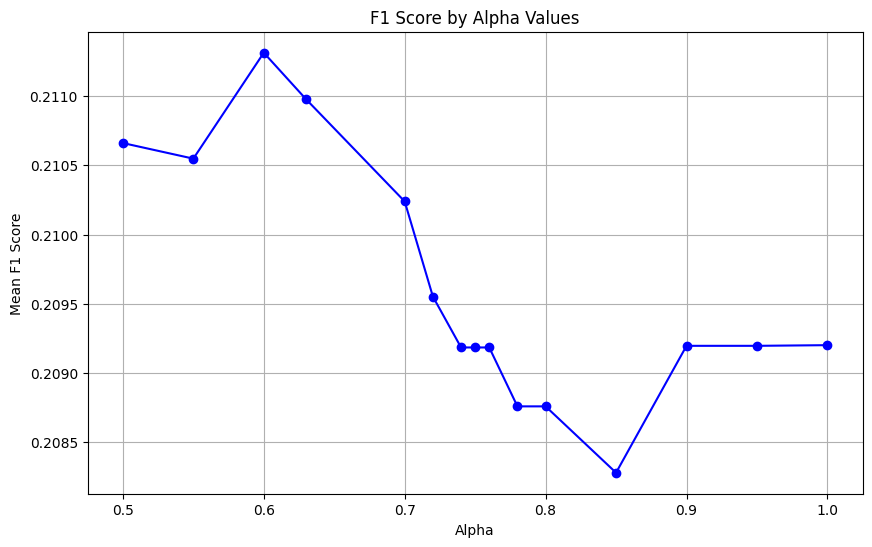

In [54]:
# Cell 9: Model Training

# Separating features and target variable
X = train_data.drop(columns=['Education'])
y = train_data['Education']

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Bernoulli Naive Bayes classifier
classifier = BernoulliNB()

# Define the parameter grid to search
param_grid = {
    'alpha': [0.5, 0.55, 0.6, 0.63, 0.7, 0.72, 0.74, 0.75, 0.76, 0.78, 0.8, 0.85, 0.9, 0.95, 1.0]
}

# Define F1 score as the scoring metric
scorer = make_scorer(f1_score, average='weighted')

# Initialize GridSearchCV with F1 score as the scoring metric
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring=scorer)


# Perform grid search on training data
grid_search.fit(X_train, y_train)

# Display the best parameters and the best model obtained
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Parameters:", best_params)

# Extract the mean test scores for each parameter setting
mean_scores = grid_search.cv_results_['mean_test_score']
alphas = [params['alpha'] for params in grid_search.cv_results_['params']]

# Plotting the relationship between alphas and their corresponding F1 scores
plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Alpha')
plt.ylabel('Mean F1 Score')
plt.title('F1 Score by Alpha Values')
plt.grid(True)
plt.show()

In [55]:
# Cell 10: Model Evaluation

# Evaluate the best model on validation data
val_f1_score = grid_search.best_score_
print("Validation F1 Score:", val_f1_score)


Validation F1 Score: 0.21131294636671308


In [56]:
# Cell 11: Prediction on Test Data

# Making predictions on the test data
test_predictions = best_model.predict(test_data)

# Converting predictions back to original labels
test_predictions_labels = label_encoder.inverse_transform(test_predictions)

# Preparing the dataframe for submission
submission_df = pd.DataFrame({'ID': test_data_all['ID'], 'Education': test_predictions_labels})
submission_df.to_csv('predicted_education.csv', index=False)
print("Predictions made and saved to 'predicted_education.csv'")


Predictions made and saved to 'predicted_education.csv'
